### This notebook is a companion to the preprint [Axon Diameter Measurements using Diffusion MRI are Infeasible](https://www.biorxiv.org/content/10.1101/2020.10.01.320507v2)  
#### Michael Paquette, Cornelius Eichner, Thomas R. Kn&ouml;sche, and Alfred Anwander  

This notebook includes the computation for every single values used in the text outside of the figures.

<a id='PageTop'></a>
#### Content (clickable)
[Table 1: Signal decay](#table1)  
[Table 2: d<sub>min</sub>](#table2)  
[Signal decay](#signalDecay)  
[SNR and standard deviation](#SNRstd)  
[Diameter limit](#dmin)  
[Volume Fraction](#volfrac)  
[Extra Axonal contamination](#extraContamin)  
[Van Gelderen convergence speed](#vgconv)  


In [15]:
import numpy as np
import prettytable as pt
import scipy.stats as ss
from vangelderen import vangelderen_cylinder_perp as vg # formula from []
from vangelderen import vangelderen_cylinder_perp_ln_terms
from scheme import expand_scheme
import matplotlib.pyplot as pl

In [2]:
# compute d_min as in Nilsson etal []
gamma = 42.515e6 * 2*np.pi #  T^-1 s^-1
def nilsson_diameter(sigma_bar, D_0, delta, G):
    # d_min =  ((768 sigma_bar D_0) / (7 gamma^2 delta G^2))^(1/4)
    # assume delta = DELTA
    # valid (expanded) around low diffusivity (aka low d_min)
    return ((768 * sigma_bar * D_0) / (7. * gamma**2 * delta * G**2))**(1/4.)

In [3]:
# convert normalized signal to percentage signal decay
def S2PD(signal):
    return (1-signal)*100

In [4]:
# formating in float
def fmt_f(val, ndigit, magscale):
    # return a string of val scaled by 10^magscale with ndigit digits 
    float_format = "{:." + str(ndigit) + "f}"
    return float_format.format(val*(10**magscale))

# formating in sci notation
def fmt_e(val, ndigit):
    # return a string of val with ndigit digits 
    float_format = "{:." + str(ndigit) + "e}"
    return float_format.format(val)

<a id='table1'></a>
## Table 1
[Back to top of the page](#PageTop)

In [5]:
# Parameter setup

# scanning parameter 
list_G = [0.04, 0.04, 0.3, 0.3] # T/m
list_DELTA = [0.01, 0.04, 0.01, 0.04] # s
list_delta = [0.01, 0.04, 0.01, 0.04] # s
scheme = np.array([a for a in zip(list_G, list_DELTA, list_delta)])

# diffusivities
D_invivo =     2.0e-9  # m^2/s   i.e. 2    (um)^2/ms
D_postmortem = 0.66e-9 # m^2/s   i.e. 0.66 (um)^2/ms

# axon diameters
diam_sma = 0.5e-6 # m i.e. 0.5 um
diam_med = 1.0e-6 # m i.e. 1.0 um
diam_big = 2.0e-6 # m i.e. 2.0 um

In [6]:
# signal compuation with Vangelderen formula with 50 terms 
S_invivo_sma = vg(D_invivo, diam_sma/2., scheme, 50)
S_invivo_med = vg(D_invivo, diam_med/2., scheme, 50)
S_invivo_big = vg(D_invivo, diam_big/2., scheme, 50)

S_postmortem_sma = vg(D_postmortem, diam_sma/2., scheme, 50)
S_postmortem_med = vg(D_postmortem, diam_med/2., scheme, 50)
S_postmortem_big = vg(D_postmortem, diam_big/2., scheme, 50)

In [7]:
# generate and print table

# formating func for rounding in the prettytable
def fmt(signal, ndigit):
    return  fmt_e(S2PD(signal), ndigit)

x_invivo = pt.PrettyTable()
x_invivo.title = 'In-vivo (D_0 = {:.2f} um^2/ms)'.format(D_invivo*1e9)
x_invivo.field_names = ["times (ms)", "Gradient (mT/m)", "d = {} um".format(diam_sma*1e6), "d = {} um".format(diam_med*1e6), "d = {} um".format(diam_big*1e6)]

for i in range(scheme.shape[0]):
    x_invivo.add_row([fmt_f(scheme[i,1], 0, 3), fmt_f(scheme[i,0], 0, 3), fmt(S_invivo_sma[i], 1), fmt(S_invivo_med[i], 1), fmt(S_invivo_big[i], 1)])

print(x_invivo)

x_postmortem = pt.PrettyTable()
x_postmortem.title = 'Postmortem (D_0 = {:.2f} um^2/ms)'.format(D_postmortem*1e9)
x_postmortem.field_names = ["times (ms)", "Gradient (mT/m)", "d = {} um".format(diam_sma*1e6), "d = {} um".format(diam_med*1e6), "d = {} um".format(diam_big*1e6)]

for i in range(scheme.shape[0]):
    x_postmortem.add_row([fmt_f(scheme[i,1], 0, 3), fmt_f(scheme[i,0], 0, 3), fmt(S_postmortem_sma[i], 1), fmt(S_postmortem_med[i], 1), fmt(S_postmortem_big[i], 1)])

print(x_postmortem)

+---------------------------------------------------------------------+
|                     In-vivo (D_0 = 2.00 um^2/ms)                    |
+------------+-----------------+------------+------------+------------+
| times (ms) | Gradient (mT/m) | d = 0.5 um | d = 1.0 um | d = 2.0 um |
+------------+-----------------+------------+------------+------------+
|     10     |        40       |  3.2e-05   |  5.2e-04   |  8.1e-03   |
|     40     |        40       |  1.3e-04   |  2.1e-03   |  3.3e-02   |
|     10     |       300       |  1.8e-03   |  2.9e-02   |  4.6e-01   |
|     40     |       300       |  7.3e-03   |  1.2e-01   |  1.8e+00   |
+------------+-----------------+------------+------------+------------+
+---------------------------------------------------------------------+
|                   Postmortem (D_0 = 0.66 um^2/ms)                   |
+------------+-----------------+------------+------------+------------+
| times (ms) | Gradient (mT/m) | d = 0.5 um | d = 1.0 um | d = 2

<a id='table2'></a>
## Table 2
[Back to top of the page](#PageTop)

In [8]:
# Parameter setup

# scanning parameter 
# Diffusivity / DELTA=delta / G
scheme = np.array([[2.00e-9, 40e-3,   40e-3],
                   [2.00e-9, 40e-3,  300e-3],                  
                   [2.00e-9, 40e-3, 1500e-3],                  
                   [0.66e-9, 40e-3,   40e-3],                  
                   [0.66e-9, 40e-3,  300e-3],                  
                   [0.66e-9, 40e-3, 1500e-3]])

# SNRs corresponding to detectable decay of 1%, 2.5% and 5%
SNRs = np.array([164, 65.6, 32.8])

In [9]:
# significance level
alpha = 0.05
result = np.zeros((scheme.shape[0], SNRs.shape[0]))
for i_s, s in enumerate(scheme):
    for i_snr, snr in enumerate(SNRs):
        # convert snr to minimum detectable
        sigma_bar = ss.norm().ppf(1-alpha) / snr
        # compute dmin
        result[i_s, i_snr] = nilsson_diameter(sigma_bar, s[0], s[1], s[2])

In [10]:
# generate and print table
x_dmin = pt.PrettyTable()
x_dmin.title = 'd_min'
x_dmin.field_names = ["Diffusivity (um^2/ms)", "times (ms)", "Gradient (mT/m)", "SNR = {}".format(SNRs[0]), "SNR = {}".format(SNRs[1]), "SNR = {}".format(SNRs[2])]

for i in range(scheme.shape[0]):
    x_dmin.add_row([fmt_f(scheme[i,0], 2, 9), fmt_f(scheme[i,1], 0, 3), fmt_f(scheme[i,2], 0, 3), fmt_f(result[i, 0], 2, 6), fmt_f(result[i, 1], 2, 6), fmt_f(result[i, 2], 2, 6)])

print(x_dmin)

+----------------------------------------------------------------------------------------------+
|                                            d_min                                             |
+-----------------------+------------+-----------------+-------------+------------+------------+
| Diffusivity (um^2/ms) | times (ms) | Gradient (mT/m) | SNR = 164.0 | SNR = 65.6 | SNR = 32.8 |
+-----------------------+------------+-----------------+-------------+------------+------------+
|          2.00         |     40     |        40       |     4.69    |    5.89    |    7.01    |
|          2.00         |     40     |       300       |     1.71    |    2.15    |    2.56    |
|          2.00         |     40     |       1500      |     0.77    |    0.96    |    1.14    |
|          0.66         |     40     |        40       |     3.55    |    4.47    |    5.31    |
|          0.66         |     40     |       300       |     1.30    |    1.63    |    1.94    |
|          0.66         |     

<a id='signalDecay'></a>
## Signal Decay
[Back to top of the page](#PageTop)

Various signal decay claims in the manuscript.

In [11]:
# section 2.2 L154: 

# scanning parameter 
G = 0.3 # T/m
DELTA = 0.04 # s
delta = 0.04 # s
# diffusivities
D = 2.0e-9  # m^2/s   i.e. 2    (um)^2/ms
# axon diameter
diam = 1.0e-6 # m i.e. 1.0 um
# Van Gelderen formula, 50 terms
signal = vg(D, diam/2., np.array([[G, DELTA, delta]]), 50)

# convert to signal decay percentage
print(fmt_f(S2PD(signal)[0], 2, 0) + " %")

0.12 %


In [12]:
# Caption of table 1: 

# scanning parameter 
G = 0.3 # T/m
DELTA = 0.04 # s
delta = 0.04 # s
# diffusivities
D = 0.66e-9  # m^2/s   i.e. 0.66    (um)^2/ms
# axon diameter
diam = 1.0e-6 # m i.e. 1.0 um
# Van Gelderen formula, 50 terms
signal = vg(D, diam/2., np.array([[G, DELTA, delta]]), 50)

# convert to signal decay percentage
print(fmt_f(S2PD(signal)[0], 2, 0) + " %")

0.35 %


In [13]:
# section 3 L395: 
# signal decays difference of 2-cylinder combination for the 3 gradient sampling scheme

# !! Values in the paper where a bit too eyeballed, will fix in new version
#  35% 5.0um + 65% 3.0um -->  35% 4.95um + 65% 2.90um
# 100% 4.0um             --> 100% 3.85um
#  45% 0.1um + 55% 5.0um --> 45%  0.10um + 55% 4.60um

# scanning parameter 
G = 0.3 # T/m
DELTA = 0.05 # s
delta = [0.03, 0.04, 0.05] # s
scheme = np.array([[G, DELTA, delta[0]],
                   [G, DELTA, delta[1]],
                   [G, DELTA, delta[2]]])

# diffusivities
D = 2.0e-9  # m^2/s
# axon diameters
d1 = 4.95e-6 # m
d2 = 2.9e-6 # m
# signal fractions
sf1 = 0.35
sf2 = 0.65
# Van Gelderen formula, 50 terms
s1 = vg(D, d1/2., scheme, 50)
s2 = vg(D, d2/2., scheme, 50)
signal1 = sf1*s1 + sf2*s2

# convert to signal decay percentage
name1 = 'comb-1: {:.0f}% ({:.2f} um) + {:.0f}% ({:.2f} um)'.format(100*sf1, d1*1e6, 100*sf2, d2*1e6)
print(name1)
print('S = [{:.2e}, {:.2e}, {:.2e}]\n'.format(*signal1))


# diffusivities
D = 2.0e-9  # m^2/s
# axon diameters
d1 = 4.5e-6 # m
d2 = 3.5e-6 # m
# signal fractions
sf1 = 0.30
sf2 = 0.70
# Van Gelderen formula, 50 terms
s1 = vg(D, d1/2., scheme, 50)
s2 = vg(D, d2/2., scheme, 50)
signal2 = sf1*s1 + sf2*s2

# convert to signal decay percentage
name2 = 'comb-2: {:.0f}% ({:.2f} um) + {:.0f}% ({:.2f} um)'.format(100*sf1, d1*1e6, 100*sf2, d2*1e6)
print(name2)
print('S = [{:.2e}, {:.2e}, {:.2e}]\n'.format(*signal2))


# diffusivities
D = 2.0e-9  # m^2/s
# axon diameters
d1 = 3.85e-6 # m
d2 = 3.85e-6 # m
# signal fractions
sf1 = 1.00
sf2 = 0.00
# Van Gelderen formula, 50 terms
s1 = vg(D, d1/2., scheme, 50)
s2 = vg(D, d2/2., scheme, 50)
signal3 = sf1*s1 + sf2*s2

# convert to signal decay percentage
name3 = 'comb-1: {:.0f}% ({:.2f} um) + {:.0f}% ({:.2f} um)'.format(100*sf1, d1*1e6, 100*sf2, d2*1e6)
print(name3)
print('S = [{:.2e}, {:.2e}, {:.2e}]\n'.format(*signal3))


# diffusivities
D = 2.0e-9  # m^2/s
# axon diameters
d1 = 0.1e-6 # m
d2 = 4.6e-6 # m
# signal fractions
sf1 = 0.45
sf2 = 0.55
# Van Gelderen formula, 50 terms
s1 = vg(D, d1/2., scheme, 50)
s2 = vg(D, d2/2., scheme, 50)
signal4 = sf1*s1 + sf2*s2

# convert to signal decay percentage
name4 = 'comb-1: {:.0f}% ({:.2f} um) + {:.0f}% ({:.2f} um)'.format(100*sf1, d1*1e6, 100*sf2, d2*1e6)
print(name4)
print('S = [{:.2e}, {:.2e}, {:.2e}]\n'.format(*signal4))

# import pylab as pl
# pl.figure(figsize=(8,6))
# pl.plot(np.array(delta)*1e3, signal1, label = name1)
# pl.plot(np.array(delta)*1e3, signal2, label = name2)
# pl.plot(np.array(delta)*1e3, signal3, label = name3)
# pl.plot(np.array(delta)*1e3, signal4, label = name4)
# pl.legend()
# pl.errorbar(np.array(delta)*1e3, np.concatenate((signal1[:,None], signal2[:,None], signal3[:,None], signal4[:,None]), axis=1).mean(axis=1), yerr=0.005)
# pl.xlabel('delta (ms)')
# pl.ylabel('Signal')
# pl.show()

comb-1: 35% (4.95 um) + 65% (2.90 um)
S = [8.21e-01, 7.75e-01, 7.36e-01]

comb-2: 30% (4.50 um) + 70% (3.50 um)
S = [8.26e-01, 7.76e-01, 7.31e-01]

comb-1: 100% (3.85 um) + 0% (3.85 um)
S = [8.27e-01, 7.76e-01, 7.29e-01]

comb-1: 45% (0.10 um) + 55% (4.60 um)
S = [8.25e-01, 7.79e-01, 7.40e-01]



<a id='SNRstd'></a>
## SNR and standard deviation
[Back to top of the page](#PageTop)

Various claim about the equivalent signal decay to 1 standard deviation of some SNR

In [14]:
# section 2.2 L157: 

target_decay = 0.0012 # 0.12 %
nb_std = 1.0 # standard deviation
# with gaussian noise and "S(b=0) = 1", 
# we have signal decay associated with 1 std equal to 1/SNR
SNR = nb_std/target_decay
print(fmt_f(SNR, 0, 0))

833


In [15]:
# section 2.2 L160: 

target_decay = 0.0012 # 0.12 %
nb_std = 2.0 # standard deviation
# with gaussian noise and "S(b=0) = 1", 
# we have signal decay associated with 1 std equal to 1/SNR
SNR = nb_std/target_decay
print(fmt_f(SNR, 0, 0))

1667


In [16]:
# Caption of table 1: 

target_decay = 0.033 # 3.3 %
nb_std = 1.0 # standard deviation
# with gaussian noise and "S(b=0) = 1", 
# we have signal decay associated with 1 std equal to 1/SNR
SNR = nb_std/target_decay
print(fmt_f(SNR, 0, 0))

30


In [17]:
# Caption of table 1: 

target_decay = 0.0035 # 0.35 %
nb_std = 2.0 # standard deviation
# with gaussian noise and "S(b=0) = 1", 
# we have signal decay associated with 1 std equal to 1/SNR
SNR = nb_std/target_decay
print(fmt_f(SNR, 0, 0))

571


In [18]:
# In Table 2:
# choice of SNRs

target_decay = 0.01 # 1.0 %
nb_std = 1.645 # equivalent to alpha 0.05
# with gaussian noise and "S(b=0) = 1", 
# we have signal decay associated with 1 std equal to 1/SNR
SNR = nb_std/target_decay
print(fmt_f(SNR, 0, 0))

164


In [19]:
# In Table 2:
# choice of SNRs

target_decay = 0.025 # 2.5 %
nb_std = 1.645 # equivalent to alpha 0.05
# with gaussian noise and "S(b=0) = 1", 
# we have signal decay associated with 1 std equal to 1/SNR
SNR = nb_std/target_decay
print(fmt_f(SNR, 1, 0))

65.8


In [20]:
# In Table 2:
# choice of SNRs

target_decay = 0.05 # 5.0 %
nb_std = 1.645 # equivalent to alpha 0.05
# with gaussian noise and "S(b=0) = 1", 
# we have signal decay associated with 1 std equal to 1/SNR
SNR = nb_std/target_decay
print(fmt_f(SNR, 1, 0))

32.9


In [21]:
# section 3 L396: 

target_decay = 0.001 # 0.1 %
nb_std = 1.645 # standard deviation
# with gaussian noise and "S(b=0) = 1", 
# we have signal decay associated with 1 std equal to 1/SNR
SNR = nb_std/target_decay
print(fmt_f(SNR, 0, 0))

1645


In [22]:
# section 3 L396: 

target_decay = 0.005 # 0.1 %
nb_std = 1.645 # standard deviation
# with gaussian noise and "S(b=0) = 1", 
# we have signal decay associated with 1 std equal to 1/SNR
SNR = nb_std/target_decay
print(fmt_f(SNR, 0, 0))

329


<a id='dmin'></a>
## Diameter limit 
[Back to top of the page](#PageTop)

Various claim about Nilsson etal diameter limit at $\alpha$ = 0.05

In [23]:
# section 2.3 L177:

# scanning parameter 
G = 0.3 # T/m
delta = 0.04 # s
# diffusivities
D = 2.00e-9  # m^2/s   i.e. 2    (um)^2/ms
# noise level
snr = 32.8
# significance level
alpha = 0.05 
# minimal detectable signal
sigma_bar = ss.norm().ppf(1-alpha) / snr
# compute dmin
dmin = nilsson_diameter(sigma_bar, D, delta, G)
print(fmt_f(dmin, 2, 6) + " um")

2.56 um


In [24]:
# section 2.3 L249:

# noiseless decay of all 3 "gradients" of fig2 
# converted into "dmin" for typical SNR = 30

snr = 30
nb_std = 1.645 # equivalent to alpha 0.05
# with gaussian noise and "S(b=0) = 1", 
# we have signal decay associated with 1 std equal to 1/SNR
target_decay = nb_std/SNR


# scanning parameter 
G = 0.3 # T/m
DELTA = 0.05 # s
delta = 0.03 # s
# diffusivities
D = 2.0e-9  # m^2/s

# building a dictionary of signal decay for this 
diams = np.linspace(1, 4, 301)*1e-6 # um
# Van Gelderen formula, 50 terms
decays = np.array([1-vg(D, diam/2., np.array([[G, DELTA, delta]]), 50) for diam in diams]).flatten()

# rough matching
dmin = diams[np.argmin(np.abs(decays - target_decay))]

print(fmt_f(dmin, 2, 6) + " um")

# scanning parameter 
G = 0.3 # T/m
DELTA = 0.05 # s
delta = 0.04 # s
# diffusivities
D = 2.0e-9  # m^2/s 

# building a dictionary of signal decay for this 
diams = np.linspace(1, 4, 301)*1e-6 # um
# Van Gelderen formula, 50 terms
decays = np.array([1-vg(D, diam/2., np.array([[G, DELTA, delta]]), 50) for diam in diams]).flatten()

# rough matching
dmin = diams[np.argmin(np.abs(decays - target_decay))]

print(fmt_f(dmin, 2, 6) + " um")

# scanning parameter 
G = 0.3 # T/m
DELTA = 0.05 # s
delta = 0.05 # s
# diffusivities
D = 2.0e-9  # m^2/s 

# building a dictionary of signal decay for this 
diams = np.linspace(1, 4, 301)*1e-6 # um
# Van Gelderen formula, 50 terms
decays = np.array([1-vg(D, diam/2., np.array([[G, DELTA, delta]]), 50) for diam in diams]).flatten()

# rough matching
dmin = diams[np.argmin(np.abs(decays - target_decay))]

print(fmt_f(dmin, 2, 6) + " um")

1.55 um
1.44 um
1.36 um


In [25]:
# section 3 L398:

# scanning parameter 
G = 0.3 # T/m
delta = 0.04 # s
# diffusivities
D = 2.00e-9  # m^2/s   i.e. 2    (um)^2/ms
# noise level
snr = 1645
# significance level
alpha = 0.05 
# minimal detectable signal
sigma_bar = ss.norm().ppf(1-alpha) / snr
# compute dmin
dmin = nilsson_diameter(sigma_bar, D, delta, G)
print(fmt_f(dmin, 2, 6) + " um")

0.96 um


In [26]:
# section 3 L398:

# scanning parameter 
G = 0.3 # T/m
delta = 0.04 # s
# diffusivities
D = 2.00e-9  # m^2/s   i.e. 2    (um)^2/ms
# noise level
snr = 329
# significance level
alpha = 0.05 
# minimal detectable signal
sigma_bar = ss.norm().ppf(1-alpha) / snr
# compute dmin
dmin = nilsson_diameter(sigma_bar, D, delta, G)
print(fmt_f(dmin, 2, 6) + " um")

1.44 um


<a id='volfrac'></a>
## Volume Fraction 
[Back to top of the page](#PageTop)

Conversion from signal fraction to volume fraction

In [27]:
# section 2.4 L239:

# signal fractions
sf1 = 0.3
sf2 = 0.7
# diameters
d1 = 4.5
d2 = 3.5
# computing volume fractions
vf1 = (sf1*d1**2) / (sf1*d1**2 + sf2*d2**2)
vf2 = (sf2*d2**2) / (sf1*d1**2 + sf2*d2**2)

print("vf1 = " + fmt_f(vf1, 1, 2) + " %")
print("vf2 = " + fmt_f(vf2, 1, 2) + " %")

vf1 = 41.5 %
vf2 = 58.5 %


<a id='extraContamin'></a>
## Extra Axonal contamination
[Back to top of the page](#PageTop)

Conversion from extraaxonal free diffusion to equivalent fake diameter.

In [28]:
# section 3 L357:

# signal decay of extra axonal compartement
gamma = 42.515e6 * 2*np.pi #  T^-1 s^-1

def bval(G, DELTA, delta):
    return (G*delta*gamma)**2 * (DELTA-(delta/3.))

# scanning parameter 
G = 0.3 # T/m
DELTA = 0.01 # s
delta = 0.01 # s
# diffusivities
D = 0.3e-9  # m^2/s
# b-value
b = bval(G, DELTA, delta)
# signal 
S = np.exp(-b*D)
# signal decay
print("extra-axonal decay = " + fmt_f(S2PD(S), 1, 0) + " %")

contamination = 0.01 # 1 % contamination 
target_decay = (contamination*(1-S))
print('target decay = {:.3f} %'.format(100*target_decay))
D0 = 2.0e-9  # m^2/s
# building a dictionary of signal decay for this 
diams = np.linspace(0.5, 3.0, 251)*1e-6 # um
# Van Gelderen formula, 50 terms
decays = np.array([1-vg(D0, diam/2., np.array([[G, DELTA, delta]]), 50) for diam in diams]).flatten()

# rough matching
dmin = diams[np.argmin(np.abs(decays - (target_decay)))]

print(fmt_f(dmin, 2, 6) + " um")

extra-axonal decay = 72.3 %
target decay = 0.723 %
2.25 um


<a id='vgconv'></a>
## Van Gelderen convergence speed
[Back to top of the page](#PageTop)

Showing the diminushing contribution of each tern in the Van Gelderen series to show fast convergeance for relevant parameter ranges.

In [4]:
# scanning parameter 
list_G = [0.04, 0.3, 0.3] # T/m
list_DELTA = [0.04, 0.01, 0.04] # s
list_delta = [0.04, 0.01, 0.04] # s
scheme = np.array([a for a in zip(list_G, list_DELTA, list_delta)])

# diffusivities
D_invivo =     2.0e-9  # m^2/s   i.e. 2    (um)^2/ms

# axon diameters
diam = 1.0e-6 # m i.e. 1.0 um

In [30]:
# get the leist of term instead of the signal
fac, comp = vangelderen_cylinder_perp_ln_terms(D_invivo, diam/2., scheme, 100)
full_signal = np.exp(fac*np.sum(comp, axis=0))

In [31]:
# cummulative sum with increasing precision
S = np.exp(fac*np.cumsum(comp[:50], axis=0))

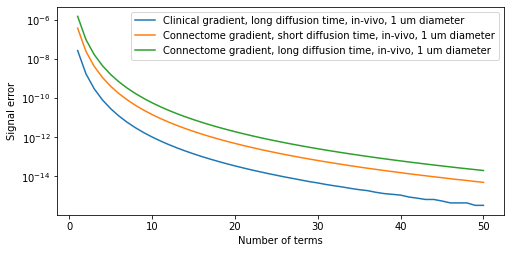

In [36]:
pl.figure(figsize=(8, 13))

pl.subplot(3,1,1)
pl.semilogy(range(1,51), S[:,0]-full_signal[0], label='Clinical gradient, long diffusion time, in-vivo, 1 um diameter')
pl.xlabel('Number of terms')
pl.ylabel('Signal error')
# pl.title('Clinical gradient, long diffusion time, in-vivo, 1 um diameter')

# pl.subplot(3,1,2)
pl.semilogy(range(1,51), S[:,1]-full_signal[1], label='Connectome gradient, short diffusion time, in-vivo, 1 um diameter')
# pl.xlabel('Number of terms')
# pl.ylabel('Signal error')
# pl.title('Connectome gradient, short diffusion time, in-vivo, 1 um diameter')

# pl.subplot(3,1,3)
pl.semilogy(range(1,51), S[:,2]-full_signal[2], label='Connectome gradient, long diffusion time, in-vivo, 1 um diameter')
# pl.xlabel('Number of terms')
# pl.ylabel('Signal error')
# pl.title('Connectome gradient, long diffusion time, in-vivo, 1 um diameter')

pl.legend()
pl.show()